## Imports

In [120]:
import re
from matplotlib import pyplot as plt

## Extracting actual text to work with

In [124]:
def selectFirstVersionForEachWord(paragraph: str) -> str:
    return re.sub(r'\((.*?)\|.*?\)', r'\1', paragraph)

def extractParagraphs(file) -> list[str]:
    paragraphs = []
    current_paragraph = ''
    
    for line in file:
        if line.strip().startswith("#") or len(line) < 2:
            continue

        last_character = line[-2]

        if last_character in ['-', '=']:
            current_paragraph += line[:-2]
        else:
            current_paragraph += line[:-1]

        if last_character == '=':
            paragraphs.append(selectFirstVersionForEachWord(current_paragraph.strip()))
            current_paragraph = ''

    return paragraphs



def extractWordsFromParagraphAndLower(paragraph: str) -> list[str]:
    return re.split(r'[\s,\.\[\]\{\}:;"]', paragraph.lower().replace('-', '').replace('_', ''))


# ------------------------------------------------------------------------- #

def readCodex(path: str) -> list[str]:
    with open(path, 'r', encoding="utf-8") as f:
        return list(map(extractWordsFromParagraphAndLower, extractParagraphs(f)))


In [127]:
def processWordsInLine(line: list[str]) -> list[str]:
    return [one_word for one_word in map(lambda word: re.sub(r'[\(\)\-»«]', '', word), line) if len(one_word) > 0]

def readUnformattedText(path: str) -> list[str]:
    with open(path, 'r', encoding="utf-8") as f:
        return map(processWordsInLine, (map(extractWordsFromParagraphAndLower, f.readlines())))


### Results - text after processing:

In [128]:
for p in readUnformattedText('slovenian_solar_system.txt'):
    print(p)

['naše', 'osónčje', 'tudi', 'sónčev', 'sistém', 'ali', 'sestàv', 'je', 'sestav', 'astronomskih', 'teles', 'ki', 'ga', 'sestavljajo', 'zvezda', 'sonce', 'in', 'množica', 'drugih', 'teles', 'ki', 'kroži', 'okrog', 'njega', 'okrog', 'sonca', 'kroži', 'osem', 'planetov', 'izmed', 'katerih', 'je', 'tretji', 'planet', 'zemlja', 'naseljen', 'poleg', 'planetov', 'sestavlja', 'osončje', 'še', 'vsaj', '158', 'naravnih', 'satelitov', 'ki', 'krožijo', 'okrog', 'planetov', 'ter', 'večje', 'število', 'preostalih', 'majhnih', 'teles', 'kot', 'so', 'asteroidi', 'planetoidi', 'kometi', 'in', 'meteoroidi']
['naše', 'osončje', 'leži', 'v', 'spiralni', 'galaksiji', 'imenovani', 'rimska', 'cesta', 'oziroma', 'kar', 'galaksija', 'z', 'veliko', 'začetnico', 'obhodni', 'čas', 'njegovega', 'tira', 'je', 'galaktično', 'leto']
['izraz', 'osončje', 'ali', 'sončni', 'sistem', 'se', 'občasno', 'uporablja', 'tudi', 'za', 'druge', 'zvezdne', 'oziroma', 'planetne', 'sestave', 'čeprav', 'so', 'mnenja', 'o', 'tem', 'del

## Counting N-Grams

In [99]:
def countNGrams(text: list[str], n: int, min_count: int) -> dict[str, int]:
    ngrams = {}

    for paragraph in text:
        for i in range(len(paragraph) - n + 1):
            ngram = ' '.join(paragraph[i:i+n])
            if ngram not in ngrams:
                ngrams[ngram] = 0
            ngrams[ngram] += 1

    return {k: v for k, v in ngrams.items() if v >= min_count}

In [100]:
def getSortedNGramsAndCalculateScores(ngrams: dict[str, int]) -> list[tuple[str, int, float]]:
    return list(map(lambda pair: (pair[1][0], pair[1][1], pair[0] / pair[1][1]), enumerate(sorted(ngrams.items(), key=lambda x: x[1], reverse=True))))

In [117]:
def plotNGramsCounts(ngrams: list[tuple[str, int, float]]):
    plt.figure(figsize=(20, 10))
    plt.bar(range(len(ngrams)), [count for _, count, _ in ngrams])
    plt.xticks(range(len(ngrams)), [word for word, _, _ in ngrams], rotation=90, fontsize=2)
    plt.show()

# Graph

In [105]:
def filterGraphByRequiringMinimalDegreeAndCount(graph: dict[str, dict[str, int]], minimal_degree: int, minimal_count: int) -> dict[str, dict[str, int]]:
    return {k: v for k, v in graph.items() if len(v) >= minimal_degree and max(v.values()) >= minimal_count}

def getWordsGraphs(text: list[str]) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    graph_forward = {}
    graph_backward = {}

    for paragraph in text:
        for i in range(len(paragraph) - 1):
            word = paragraph[i]
            next_word = paragraph[i+1]

            if word not in graph_forward:
                graph_forward[word] = {next_word: 1}
            else:
                next_words = graph_forward[word]
                if next_word not in next_words:
                    next_words[next_word] = 1
                else:
                    next_words[next_word] += 1

            if next_word not in graph_backward:
                graph_backward[next_word] = {word: 1}
            else:
                previous_words = graph_backward[next_word]
                if word not in previous_words:
                    previous_words[word] = 1
                else:
                    previous_words[word] += 1

    return (graph_forward, graph_backward)

def getFilteredWordsGraph(text: list[str], minimal_degree: int, minimal_count: int) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    graph_forward, graph_backward = getWordsGraphs(text)
    filtered_graph_forward = filterGraphByRequiringMinimalDegreeAndCount(graph_forward, minimal_degree, minimal_count)
    filtered_graph_backward = filterGraphByRequiringMinimalDegreeAndCount(graph_backward, minimal_degree, minimal_count)

    all_words_preceding = set(filtered_graph_forward.keys())
    all_words_following = set(filtered_graph_backward.keys())

    return ({k: {word: count for word, count in v.items() if word in all_words_following} for k, v in filtered_graph_forward.items()},
            {k: {word: count for word, count in v.items() if word in all_words_preceding} for k, v in filtered_graph_backward.items()})

In [106]:
def drawBipartialGraph(graph: (dict[str, dict[str, int]], dict[str, dict[str, int]]), title: str, print_labels: bool = False):
    plt.figure(figsize=(30, 30))
    plt.title(title)
    plt.axis('off')

    graph_network_forward, graph_network_backward = graph

    max_degree_first_word = max(map(len, graph_network_forward.values()))
    max_degree_second_word = max(map(len, graph_network_backward.values()))

    max_count= max(map(max, map(lambda x: x.values(), graph_network_forward.values())))

    all_words = set(graph_network_forward.keys())
    for words in graph_network_forward.values():
        all_words.update(words.keys())

    all_words_list = list(all_words)
    all_words_list.sort()

    word_to_index = {word: i for i, word in enumerate(all_words_list)}

    for word, words in graph_network_forward.items():
        for next_word in words.keys():
            count = graph_network_forward[word][next_word]
            count_scaled = count / max_count

            degree_scaled_first_word = len(words) / max_degree_first_word
            degree_scaled_second_word = len(graph_network_backward[next_word]) / max_degree_second_word

            first_word_y = word_to_index[word]
            second_word_y = word_to_index[next_word]

            plt.plot([0, 1], [first_word_y, second_word_y],
                     color=(0, 0,
                            count_scaled, 1))
            
            if print_labels:
                plt.text(0, first_word_y, word, horizontalalignment='right')
                plt.text(1, second_word_y, next_word, horizontalalignment='left')

    plt.show()

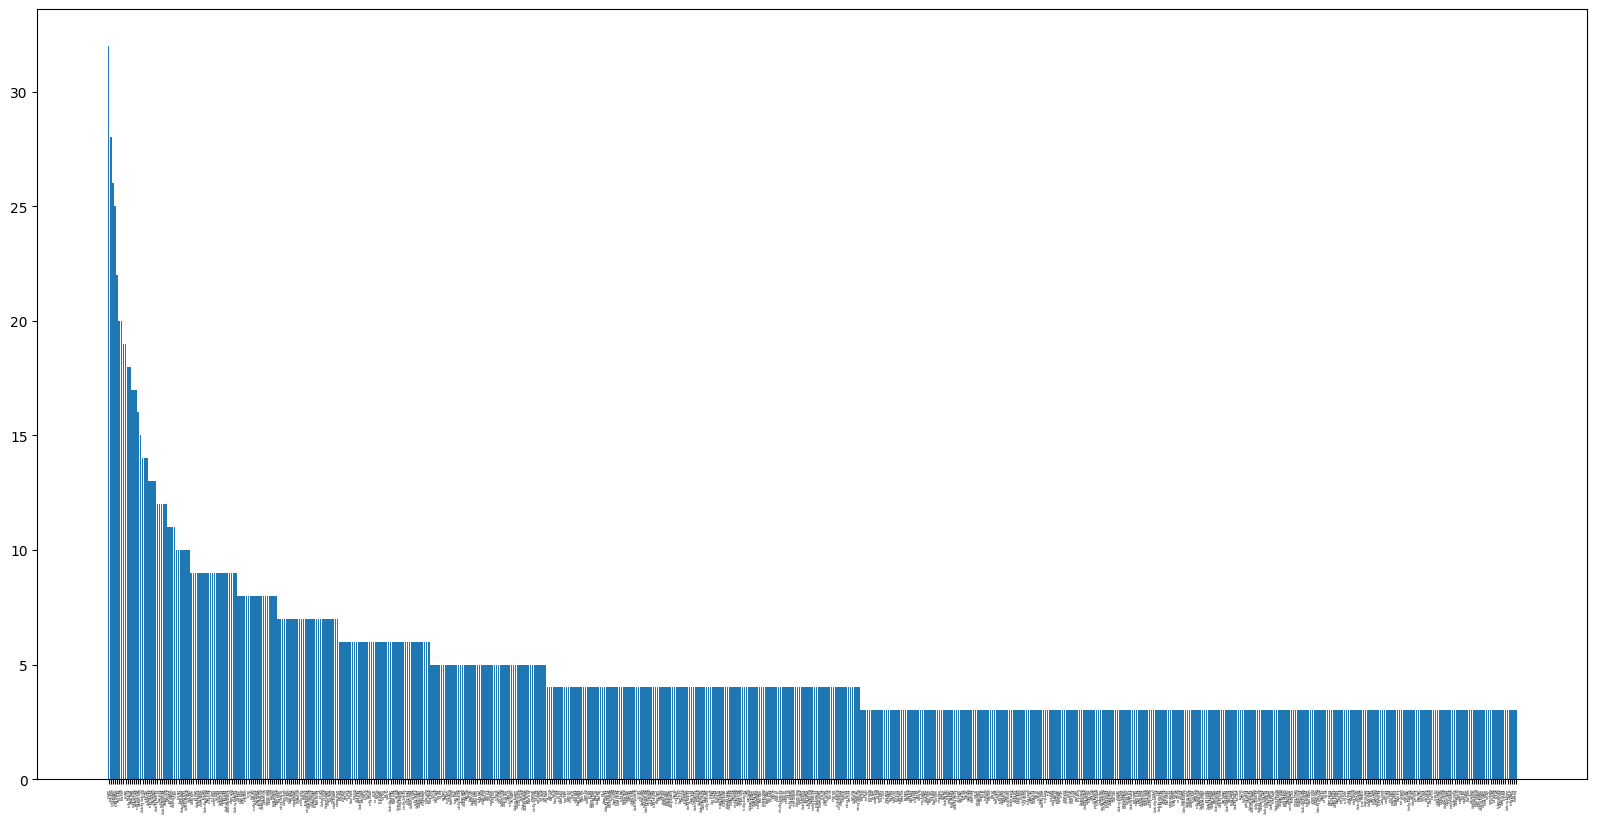

In [118]:
plotNGramsCounts(getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 2, 3)))

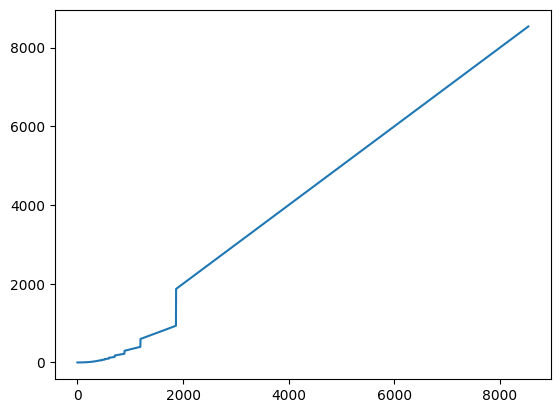

In [41]:
getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1))

plt.plot(list(map(lambda x: x[2], getSortedNGramsAndCalculateScores(countNGrams(readCodex('FSG.txt'), 1)))))

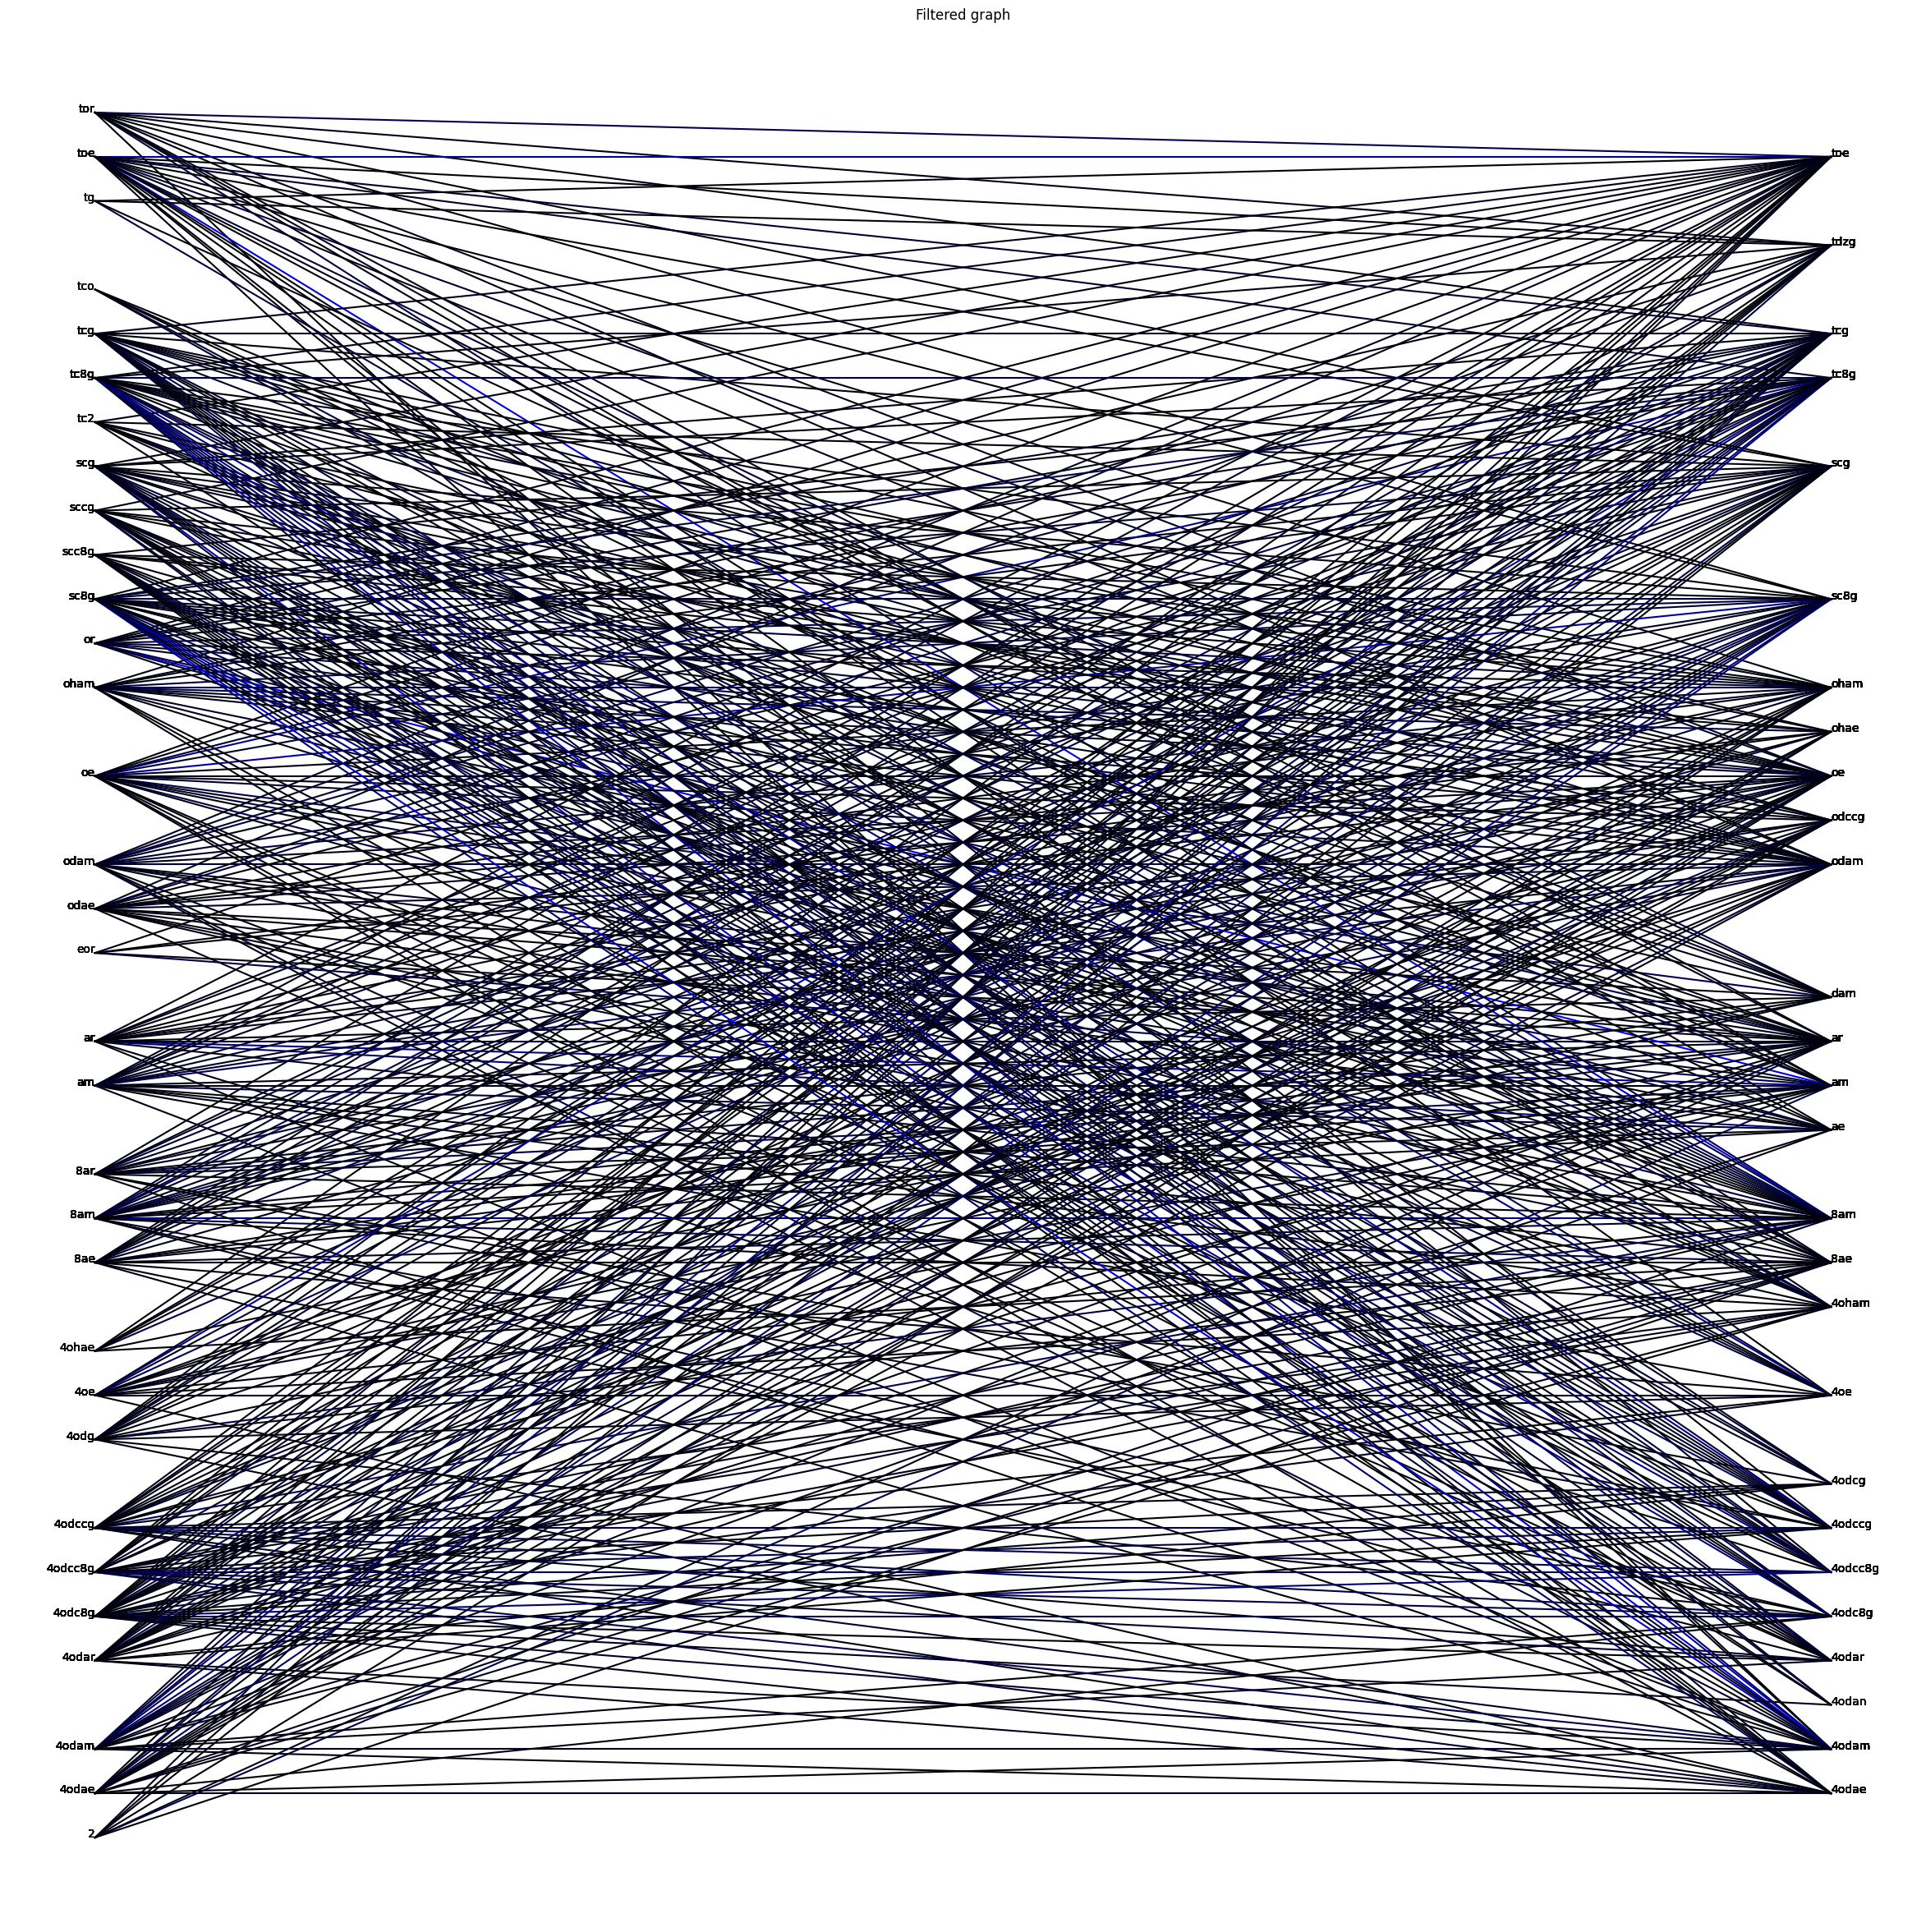

In [96]:
drawBipartialGraph(getFilteredWordsGraph(readCodex('FSG.txt'), 1, 8), 'Filtered graph', True)